# FaceForensics++: Learning to Detect Manipulated Facial Images
##### Inspired from : https://arxiv.org/abs/1901.08971v1

## Problem Definition:
#####  As there is a lot of active research going on image/video generation and manipulation, that helps to evolve many new ways to manipulate the original sources at the same time this leads to a loss of trust in digital content, but it might even cause further harm by spreading false information and the creation of fake news. 

#### Have look at this video, seems very realistic but it is actually manipulated 

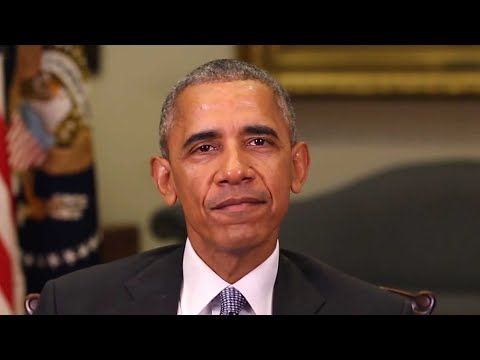

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('cQ54GDm1eL0') #Reference:https://www.youtube.com/watch?v=cQ54GDm1eL0

#### NOTE: The video I have included here, is not to offend anyone. This is just an example how digital content is losing the trust and just to address the problem for this case study    

## Objective

#### We need to build a model such that it should recognize whether the given video(or  image sequence) is  fake or real. 

## Data Background

#### The Faceforensics++ data was collected by Visual Computing Group (http://niessnerlab.org/) , one can obtain this data on accepting their terms and conditions. To download and extract the data please visit https://github.com/ondyari/FaceForensics

#### Brief summery about Data Acquisition by Faceforensics++
1. Total 1000 videos (videos are like news readers reading news) are downloaded from youtube.
2. Manipulated vidoes are generated by using 3 automated state-of-the-art face manipulation methods (viz., DeepFakes, FaceSwap, Face2Face) that are applied to these 1,000  pristine videos.
3. Gathering the images from both pritine videos(real) and manipulated videos(fake)

To get more understanding please visit https://arxiv.org/pdf/1901.08971v1.pdf 

## Data Gathering

#### 1. I have downloaded total of 100 raw videos (50 original+50 manipulated) on accepting terms and conditions mentioned in FaceForensics++ github page
#### 2. For each video each folder is created with the same name and placed the extracted images in these repective folders 

### To get the total guidence for downloading and extracting data please reach out   https://github.com/ondyari/FaceForensics 


##  The idea of  forgery detection pipeline 

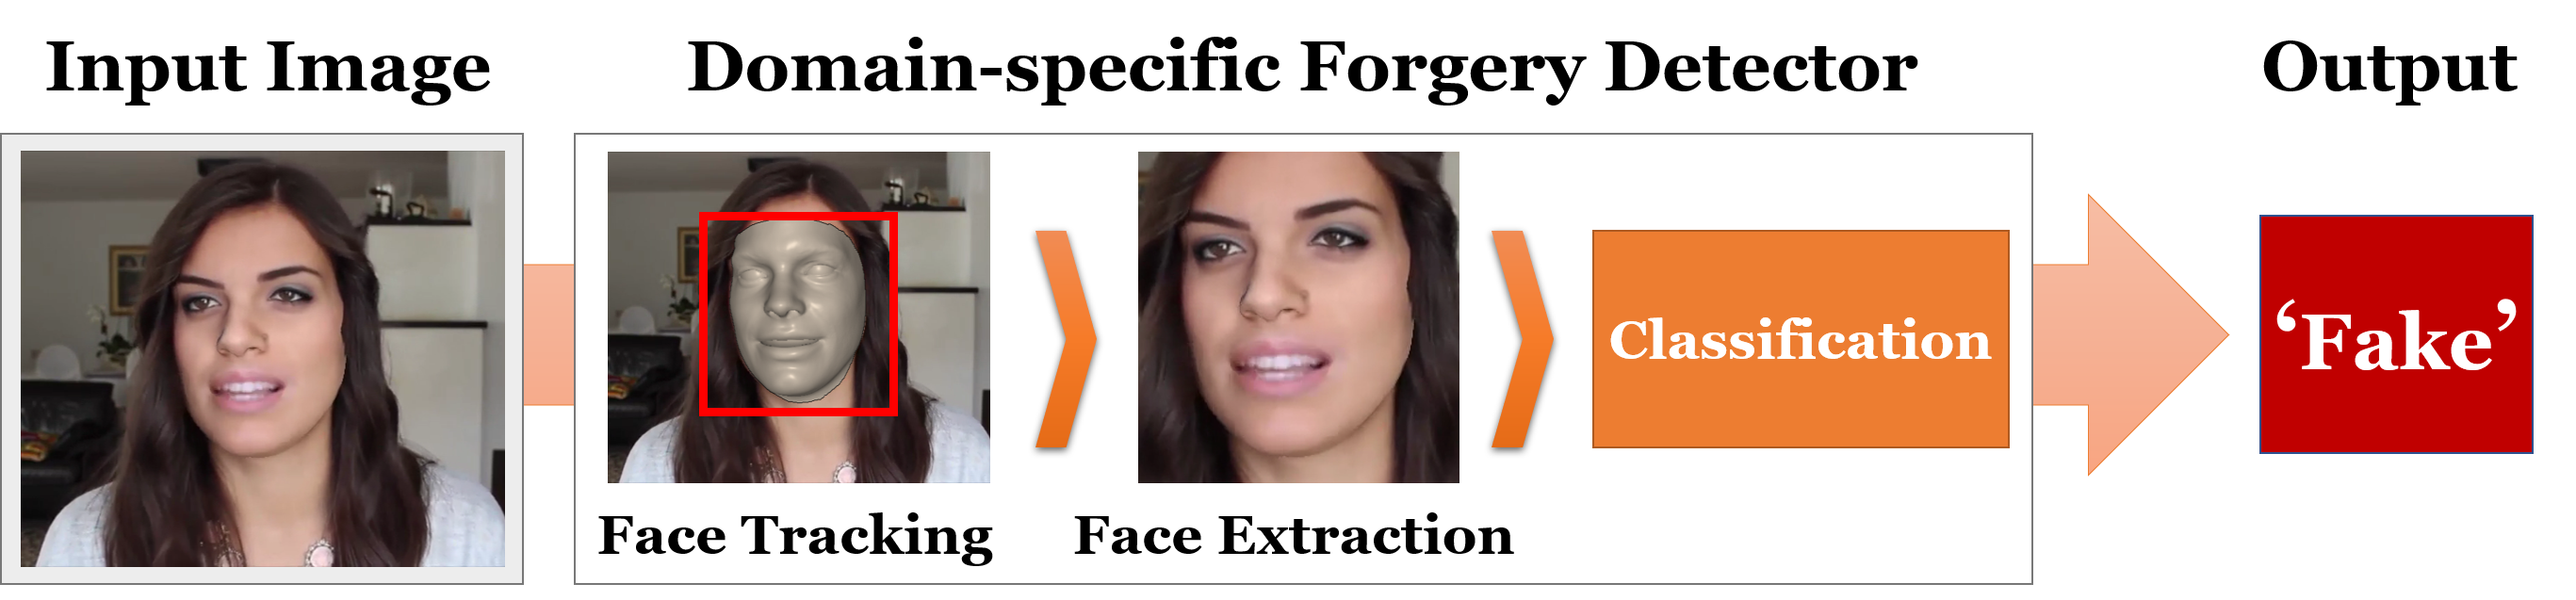

In [1]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

In [2]:
DATASET_PATHS = {
    'original': 'original_sequences/youtube',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
}

### Lets observe extracted images form each type

In [7]:
images = []
for path in DATASET_PATHS:
    for seq in os.listdir(DATASET_PATHS[path]+'/raw/images/')[:1]:
        for image in os.listdir(DATASET_PATHS[path]+'/raw/images/'+seq)[:1]:
            img = cv2.imread(DATASET_PATHS[path]+'/raw/images/'+seq+'/'+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append([img,path])
         

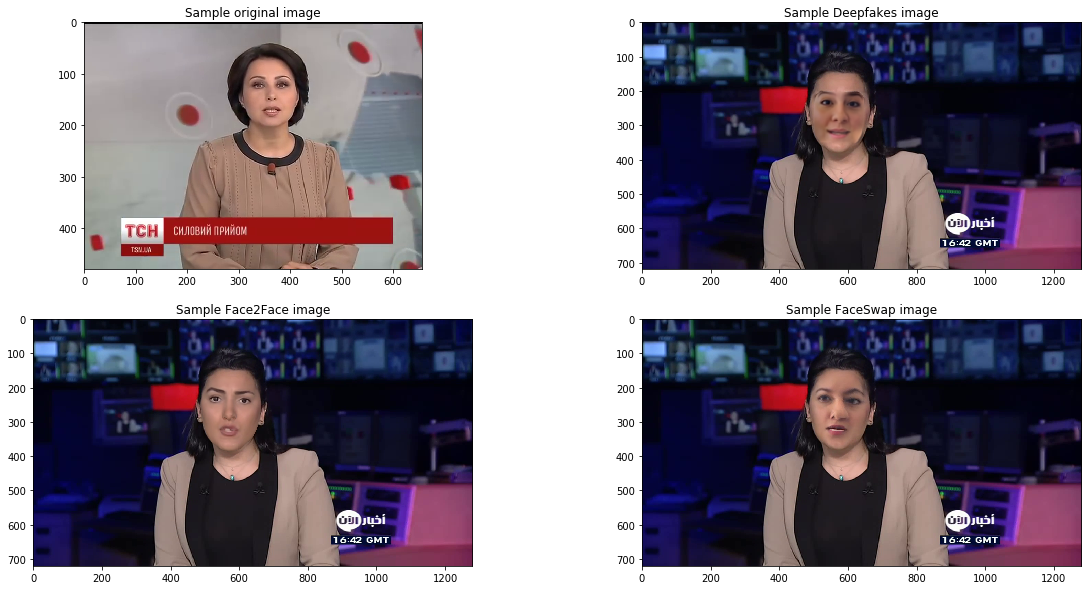

In [8]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Sample {} image".format(images[i][1]))
    plt.imshow(images[i][0])

### We are only interested in face part, Hence tracking only faces in the images 

In [9]:
def get_predicition(image):
    """Expects the image input, this image further cropped to face
    and the cropped face image will be sent for evalution funtion 
    finally 
    returns the annotated reusult with bounding box around the face. 
    """
    height, width = image.shape[:2]
    try: # If in case face is not detected at any frame
        face = face_detector(image, 1)[0]  # Face detection
        x, y, size = get_boundingbox(face=face, width=width, height=height) # Calling to get bound box around the face
    except IndexError:
        pass
    cropped_face = image[y:y+size, x:x+size] # cropping the face 
    output,label = evaluate(cropped_face) # Sending the cropped face to get classifier result 
    font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
    thickness = 2
    font_scale = 1
    if label=='Real':
        color = (0,255, 0)
    else:
        color = (0, 0, 255)
    x = face.left()    # Setting the bounding box on uncropped image
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    cv2.putText(image, label+'_'+str('%.2f'%output)+'%', (x, y+h+30), 
            font_face, font_scale,
            color, thickness, 2) # Putting the label and confidence values

    return cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)# draw box over face

In [10]:
cropped_face =[]
for image in images:
    faces = face_detector(image[0], 1)
    height, width = image[0].shape[:2]
    try: # If in case face is not detected at any frame 
        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
    except IndexError:
        continue
    cropped_face.append([image[0][y:y+size, x:x+size],image[1]])

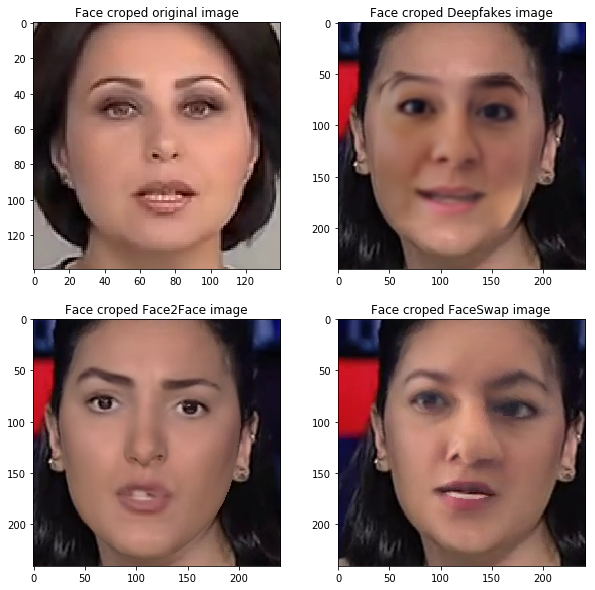

In [11]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Face croped {} image".format(cropped_face[i][1]))
    plt.imshow(cropped_face[i][0])

#### We repeat the same process for every image , before that lets split the data into Train, Cv, Test 

## Data Splitting

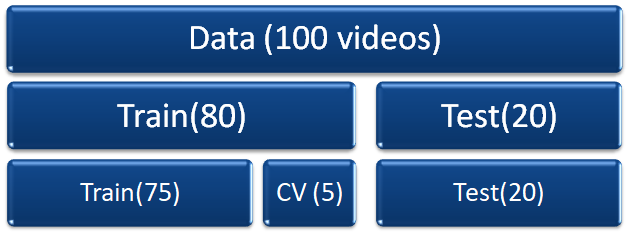

### Balance and Split  the data     

#### Train - Test split
    Data
      |--Train
          |--Real (37 videos)
          |--Fake (13,13,12) =====> (13 Deepfakes, 13 FaceSwap, 12 Face2Face)
      |--Cv
          |--Real (2)
          |--Fake (1,1,1)
      |--Test
          |--Real (10)
          |--Fake (3,3,4)

#### As there is a large sequnece in each video, tracking face in every image may increase the data redendancy, hence the idea is to track the face only in 101 frames by neglecting 1st 10 frames

#### Finally for each video we are obtaining 101 face tracked frames

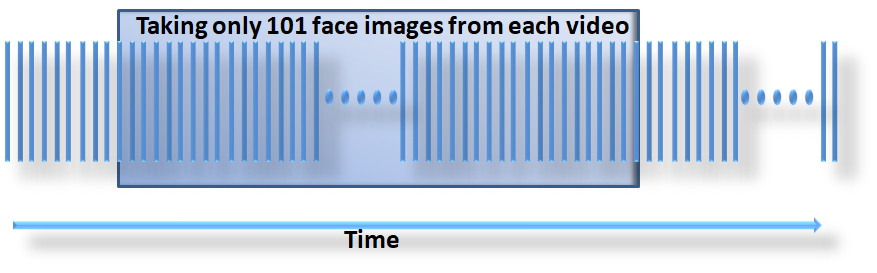

### Creating Train, Test, CV split lists

In [3]:
train_original = (os.listdir(DATASET_PATHS['original']+'/raw/images/'))[:37]
train_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/raw/images/'))[:13]
train_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/raw/images/'))[:13]
train_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/raw/images/'))[:13]
train = [train_original,train_Deepfakes,train_FaceSwap,train_Face2Face]
types = ['original','Deepfakes','FaceSwap','Face2Face']

In [4]:
cv_original = (os.listdir(DATASET_PATHS['original']+'/raw/images/'))[37:][:2]
cv_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/raw/images/'))[13:][:1]
cv_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/raw/images/'))[13:][:1]
cv_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/raw/images/'))[13:][:1]
cv = [cv_original,cv_Deepfakes,cv_FaceSwap,cv_Face2Face]

In [5]:
test_original = (os.listdir(DATASET_PATHS['original']+'/raw/images/'))[-11:-1]
test_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/raw/images/'))[-4:-1]
test_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/raw/images/'))[-4:-1]
test_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/raw/images/'))[-5:-1]
test = [test_original,test_Deepfakes,test_FaceSwap,test_Face2Face]

In [356]:
def track_face(split_type,Split,output_mkdir=True):
    """
    Expects a splited data list and generates face tracked images.
    :split_type: list video names for train/test/cv
    :Split: train/test/cv in str format
    This function will generate face tracked images for train/test/cv data
    and will place the same in corresponding directory 
    """
    
    for part in zip(split_type,types):
        for video in tqdm(part[0]):
            if output_mkdir==True:
                os.makedirs('Data/'+Split+'/'+part[1]+'/'+video, exist_ok=True)
            input_path = DATASET_PATHS[part[1]]+'/raw/images/'+video
            output_path = 'Data/'+Split+'/'+part[1]+'/'+video
            images = os.listdir(input_path)
            images.sort(key=lambda x: os.path.getmtime(input_path+'/'+x))
            for img in images[10:111]: #Taking 101  frames from each video
                image = cv2.imread(input_path+'/'+img)
                faces = face_detector(image, 1)
                height, width = image.shape[:2]
                try: # If in case face is not detected at any frame 
                    x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                except IndexError:
                    continue
                cropped_face = image[y:y+size, x:x+size]
                cv2.imwrite(output_path+'/'+img,cropped_face)     

In [ ]:
track_face(split_type=train,Split='train')

In [ ]:
track_face(split_type=test,Split='test')

In [ ]:
track_face(split_type=cv,Split='cv')

### Directory structure after data split

In [ ]:
"""
Data
├── cv
│   ├── Deepfakes
│   │   └── 339_392 # Folders are created with video names
│   ├── Face2Face
│   │   └── 339_392 #Each folder contains face cropped image sequnece (101 frames) for this named video
│   ├── FaceSwap
│   │   └── 720_672
│   └── original
│       ├── 392
│       └── 830
├── test
│   ├── Deepfakes
│   │   ├── 339_392
│   │   ├── 481_469
│   │   └── 720_672
│   ├── Face2Face
│   │   ├── 252_266
│   │   ├── 339_392
│   │   ├── 481_469
│   │   └── 720_672
│   ├── FaceSwap
│   │   ├── 339_392
│   │   ├── 481_469
│   │   └── 720_672
│   └── original
│       ├── 147
│       ├── 192
│       ├── 585
│       ├── 644
│       ├── 672
│       ├── 811
│       ├── 828
│       ├── 945
│       ├── 980
│       └── 992
└── train
    ├── Deepfakes
    │   ├── 033_097
    │   ├── 183_253
    │   ├── 252_266
    │   ├── 253_183
    │   ├── 266_252
    │   ├── 392_339
    │   ├── 469_481
    │   ├── 585_599
    │   ├── 599_585
    │   ├── 672_720
    │   ├── 828_830
    │   ├── 830_828
    │   └── 878_866
    ├── Face2Face
    │   ├── 033_097
    │   ├── 183_253
    │   ├── 252_266
    │   ├── 253_183
    │   ├── 266_252
    │   ├── 392_339
    │   ├── 469_481
    │   ├── 585_599
    │   ├── 599_585
    │   ├── 672_720
    │   ├── 828_830
    │   ├── 830_828
    │   └── 878_866
    ├── FaceSwap
    │   ├── 183_253
    │   ├── 252_266
    │   ├── 253_183
    │   ├── 266_252
    │   ├── 339_392
    │   ├── 392_339
    │   ├── 469_481
    │   ├── 585_599
    │   ├── 599_585
    │   ├── 672_720
    │   ├── 828_830
    │   ├── 830_828
    │   └── 878_866
    └── original
        ├── 033
        ├── 035
        ├── 036
        ├── 044
        ├── 055
        ├── 097
        ├── 134
        ├── 159
        ├── 175
        ├── 183
        ├── 241
        ├── 252
        ├── 253
        ├── 263
        ├── 266
        ├── 272
        ├── 284
        ├── 339
        ├── 396
        ├── 469
        ├── 481
        ├── 599
        ├── 648
        ├── 654
        ├── 657
        ├── 712
        ├── 716
        ├── 720
        ├── 866
        ├── 878
        ├── 917
        ├── 920
        ├── 924
        ├── 942
        ├── 943
        ├── 986
        └── 994
"""
#

### Checking some of the face tracked images in each split and category

In [97]:
def show_samples(split_name, category):
    """
    Expects a split type ("test"/"train"/"cv") and categoty (video type)
    and displays the 1st 20 face tracked images for a given
    split_name and category
    example : 
    show_samples(split_name="train", category="original")
    """
    category_ =[category]
    if split_name=='cv':
        videos= cv[types.index(category)][0]
    else:
        videos = [train[types.index(cat)] if split_name=='train' else test[types.index(cat)] for cat in category_][0][2]
    plt.figure(figsize=(10,10))
    for video in [videos]:
        frames=os.listdir('Data/'+split_name+'/'+category+'/'+video) 
        j=0
        seq = os.listdir('Data/'+split_name+'/'+category+'/'+video)
        seq.sort(key=lambda x: os.path.getmtime('Data/'+split_name+'/'+category+'/'+video+'/'+x))
        for i,image in enumerate(seq):     
            if j==20:
                break
            plt.subplot(4,5,1+i)
            img = cv2.imread('Data/'+split_name+'/'+category+'/'+video+'/'+'/'+image)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            j = j+1
        break
    plt.show()

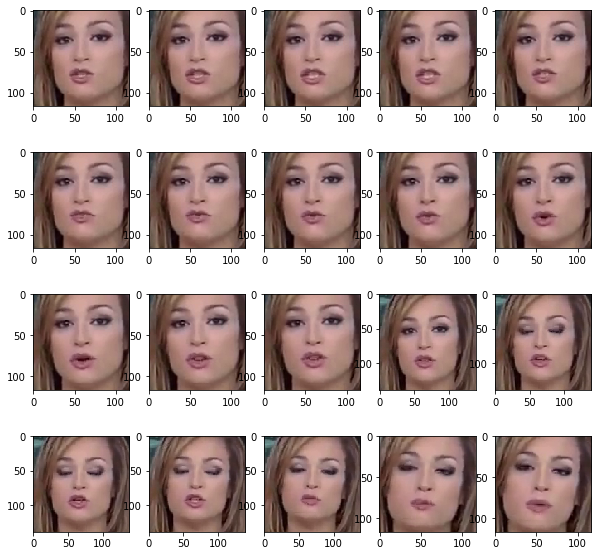

In [96]:
show_samples(split_name="train", category='original')

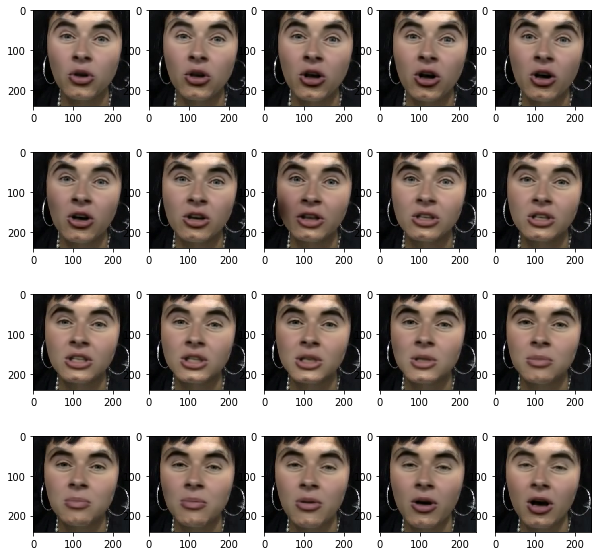

In [98]:
show_samples(split_name="cv", category='Deepfakes')

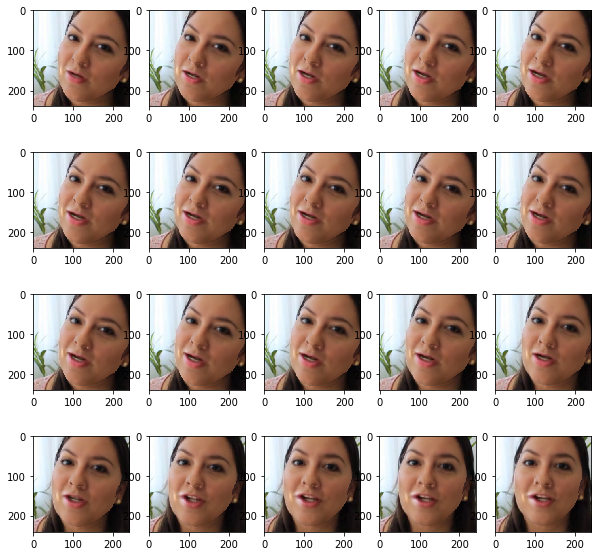

In [84]:
show_samples(split_name="test", category='Face2Face')

### Data Preprocessing and storing

1. Shuffle the videos 
2. Read the face cropped images and resizing to 299X299
3. Assigning class label to every image 1 or 0 (Fake =1 and Real =0)
4. Preprocessing the data and pickiling

In [14]:
#Created to shuffle the videos
train_=[]
for ind,i in enumerate(train):
    for j in i:
        train_.append(j+'_'+types[ind])
test_=[]
for ind,i in enumerate(test):
    for j in i:
        test_.append(j+'_'+types[ind])
        
cv_=[]
for ind,i in enumerate(cv):
    for j in i:
        cv_.append(j+'_'+types[ind])

In [15]:
TRAIN_DATADIR = "Data/train"
TEST_DATADIR = "Data/test"
CV_DATADIR = 'Data/cv'
#CLASSES = ["original", "Deepfakes","FaceSwap","Face2Face"]

In [16]:
def create_data(DATADIR,shuffled_list):
    """
    Expects Data Directory and suffled videos list
    and will returns list of image arrays and its class label (1 or 0)
    return X,y => image_arrays, class_labels
    """
    data = []
    for name in shuffled_list: 
        label = name.split('_')[-1] 
        class_num = 0
        folder_name = name.split('_')[0]
        #seq = os.listdir(DATADIR+'/'+name.split('_')[-1])
        if len(name.split('_'))==3:
            class_num=1
            folder_name = name.split('_')[0]+'_'+name.split('_')[1]
        files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
        path = DATADIR+'/'+label+'/'+folder_name
        files.sort(key=lambda x: os.path.getmtime(DATADIR+'/'+label+'/'+folder_name+'/'+x))     
        for img in tqdm(files):           
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (299, 299))
                data.append([new_array, class_num])
            except Exception as e:
                print(str(e))
            
    print("Data gathering completed......\n Separating features and class lables")
    X = []
    y = []
    for row in tqdm(data):
        X.append(row[0])
        y.append(row[1])
    X = np.array(X).reshape(-1, 299, 299, 3)
    print("Done")
    return X,y

In [ ]:
np.random.shuffle(train_)
X_train,Y_train = create_data(DATADIR=TRAIN_DATADIR,
                        
                        shuffled_list=train_)

In [ ]:
np.random.shuffle(test_)

X_test,Y_test = create_data(DATADIR=TEST_DATADIR,
                        
                        shuffled_list=test_)

In [ ]:
X_cv,Y_cv = create_data(DATADIR=CV_DATADIR,
                        
                        shuffled_list=cv_)

In [20]:
X_train = preprocess_input(X_train)
X_cv = preprocess_input(X_cv)
X_test = preprocess_input(X_test)

In [21]:
joblib.dump(X_train, 'x_train.pkl')
joblib.dump(X_test, 'x_test.pkl')
joblib.dump(Y_test, 'y_test.pkl')
joblib.dump(Y_train, 'y_train.pkl')
joblib.dump(X_cv, 'x_cv.pkl')
joblib.dump(Y_cv, 'y_cv.pkl')

['y_cv.pkl']